In [1]:
import sys
sys.path.insert(0, "/content/drive/MyDrive/MuseGan/musegan")

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn

In [3]:
from gan import Reshape, initialize_weights
from gan import TemporalNetwork
from gan import BarGenerator
from gan import MuseGenerator
from gan import MuseDiscriminator

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
tempnet = TemporalNetwork()
x = torch.rand(10, 32)
tempnet(x).shape

torch.Size([10, 32, 2])

**BarGenerator**

In [6]:
bargenerator = BarGenerator()
a = torch.rand(10, 128)
bargenerator(a).shape

torch.Size([10, 1, 1, 16, 84])

**Generator**

In [7]:
generator = MuseGenerator()

cords = torch.rand(10, 32)
style = torch.rand(10, 32)
melody = torch.rand(10, 4, 32)
groove = torch.rand(10, 4, 32)

generator(cords, style, melody, groove).shape

torch.Size([10, 4, 2, 16, 84])

**Discriminator**

In [8]:
discriminator = MuseDiscriminator()
a = torch.rand(10, 4, 2, 16, 84)
discriminator(a).shape

torch.Size([10, 1])

**Dataset Loader**


In [10]:
from torch.utils.data import DataLoader
from data import MidiDataset

dataset = MidiDataset(path='/content/drive/MyDrive/MuseGan/musegan/data/chorales/Jsb16thSeparated.npz')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

In [11]:
dataset[0].shape

torch.Size([4, 2, 16, 84])

<h1>Define Models</h1>

**Generator**

In [12]:
generator = MuseGenerator(z_dimension=32, hid_channels=1024, hid_features=1024, out_channels=1).to(device)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.9))

In [13]:
discriminator = MuseDiscriminator(hid_channels=128,
                                hid_features=1024,
                                out_features=1).to(device)
c_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.9))

In [14]:
generator = generator.apply(initialize_weights)
discriminator = discriminator.apply(initialize_weights)

**Training**

In [15]:
from trainer import Trainer

In [16]:
trainer = Trainer(generator, discriminator, g_optimizer, c_optimizer, device=device)

In [17]:
trainer.train(dataloader, epochs=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 0/2000 | Generator loss: 9.025 | Discriminator loss: -60.417
(fake: -4.226, real: -181.613, penalty: 125.421)
Epoch 10/2000 | Generator loss: -173.827 | Discriminator loss: -165.636
(fake: 153.038, real: -421.835, penalty: 103.161)
Epoch 20/2000 | Generator loss: -168.926 | Discriminator loss: -26.754
(fake: 157.289, real: -193.686, penalty: 9.643)
Epoch 30/2000 | Generator loss: -156.833 | Discriminator loss: -23.593
(fake: 130.185, real: -161.258, penalty: 7.479)
Epoch 40/2000 | Generator loss: -63.719 | Discriminator loss: -19.638
(fake: 80.589, real: -106.561, penalty: 6.334)
Epoch 50/2000 | Generator loss: -84.692 | Discriminator loss: -19.948
(fake: 84.334, real: -111.174, penalty: 6.892)
Epoch 60/2000 | Generator loss: -42.137 | Discriminator loss: -24.311
(fake: 48.221, real: -81.162, penalty: 8.630)
Epoch 70/2000 | Generator loss: -50.135 | Discriminator loss: -23.858
(fake: 47.273, real: -79.248, penalty: 8.116)
Epoch 80/2000 | Generator loss: -35.851 | Discriminator lo

In [18]:
losses = trainer.data.copy()

**Save losses**

In [19]:
import pandas as pd

df = pd.DataFrame.from_dict(losses)
df.to_csv('results.csv', index=False)

**Save models**

In [20]:
generator = generator.eval().cpu()
discriminator = discriminator.eval().cpu()
torch.save(generator, 'generator_e1000.pt')
torch.save(discriminator, 'discriminator_e1000.pt')

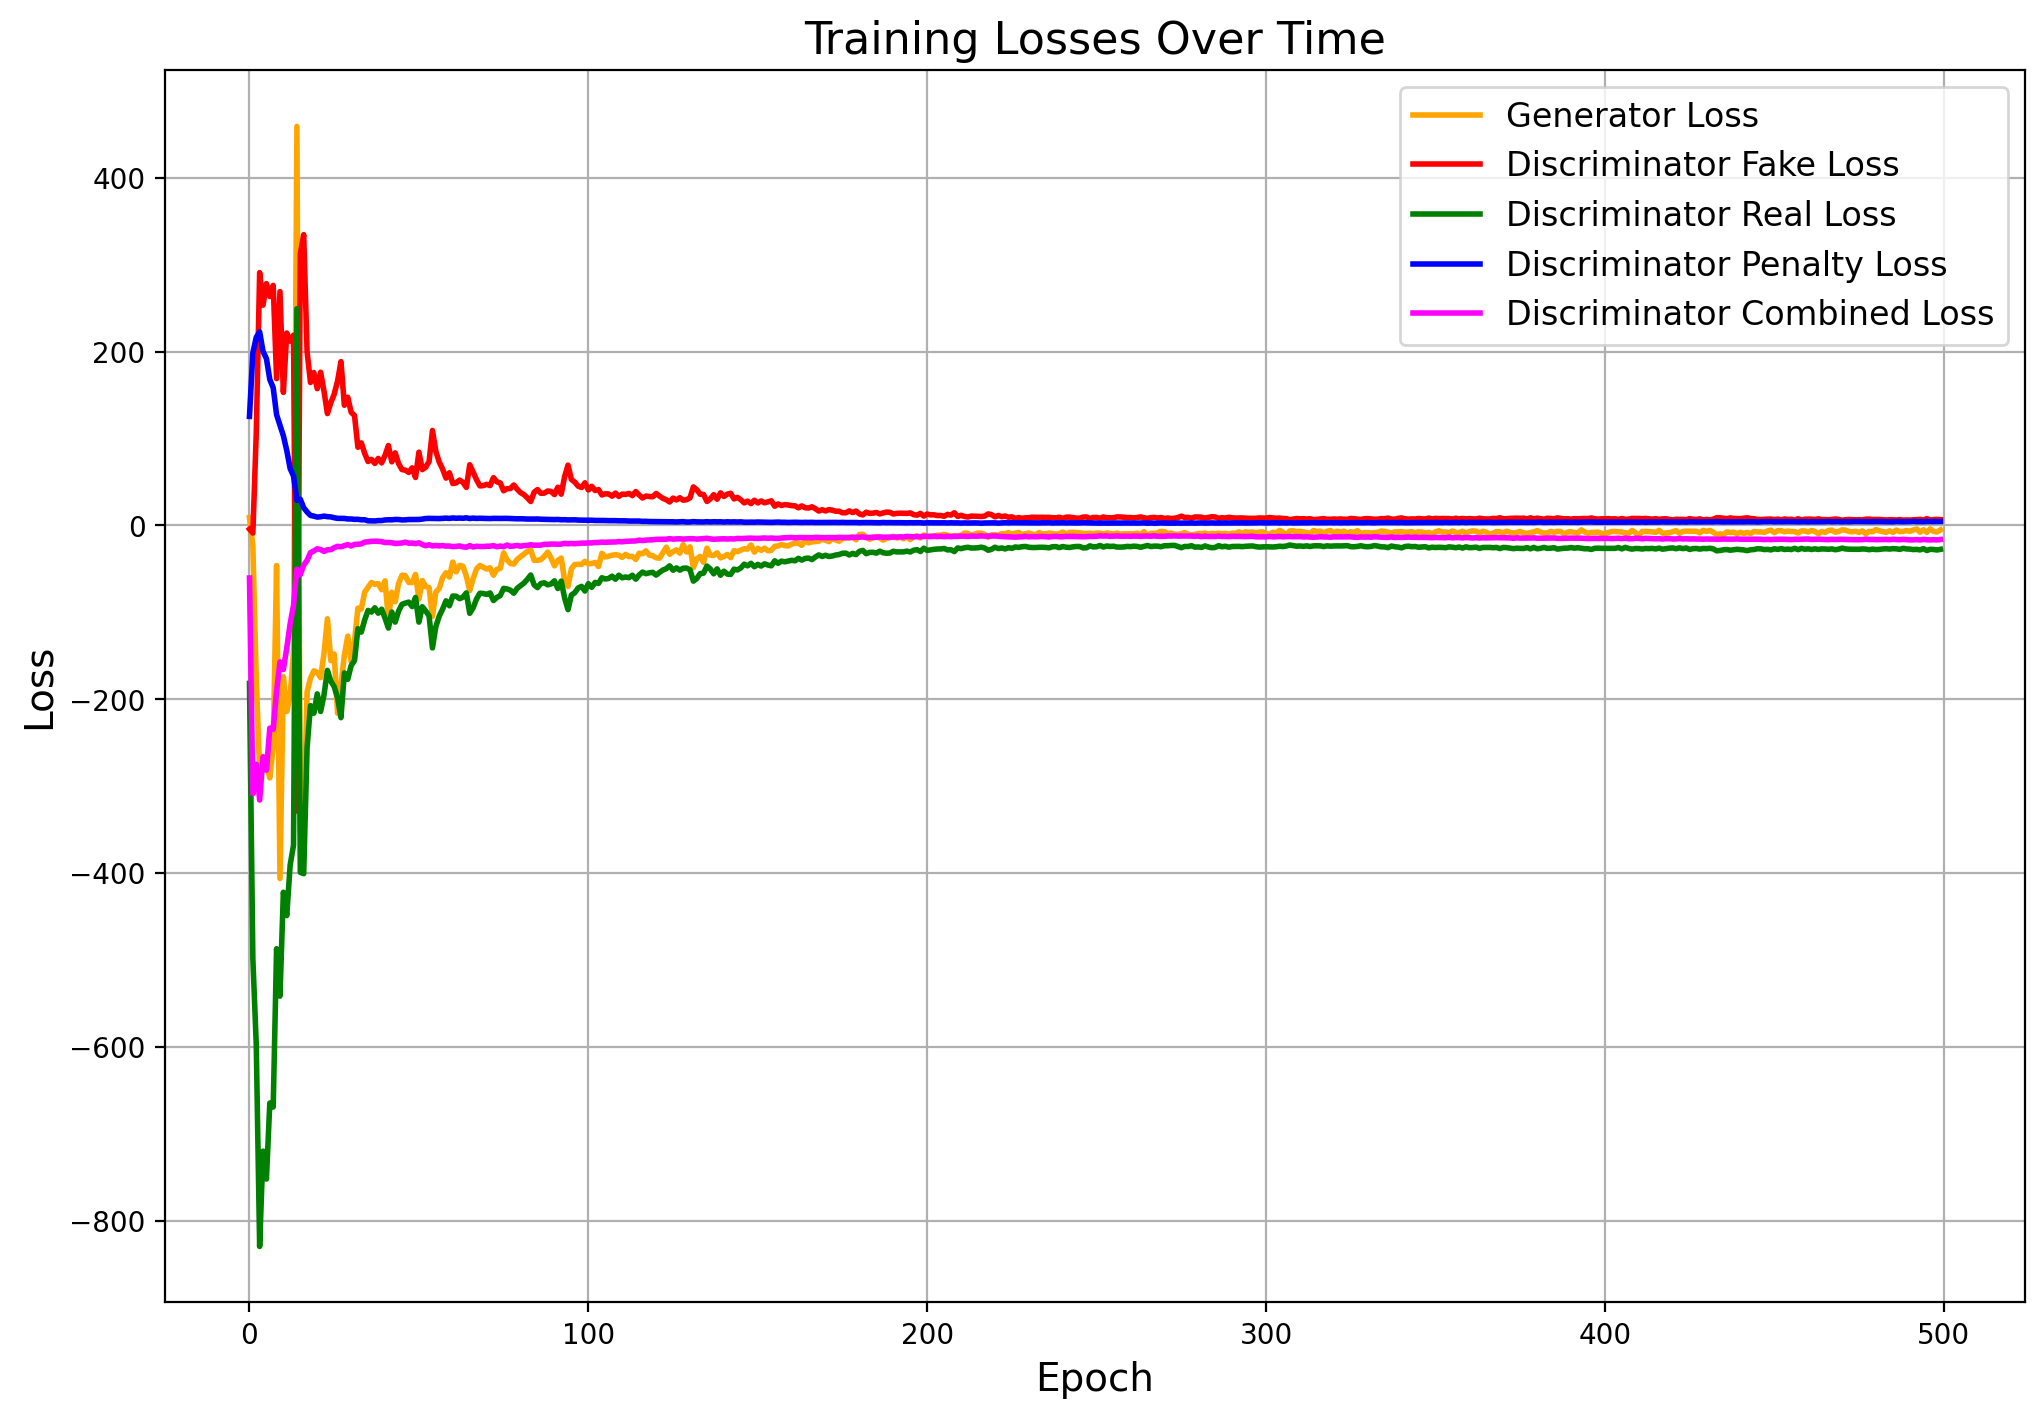

In [21]:
plt.figure(figsize=(12, 8))

# Plotting each loss with distinct colors and more descriptive labels.
plt.plot(losses['gloss'][:500], color='orange', linewidth=2, label='Generator Loss')
plt.plot(losses['cfloss'][:500], color='red', linewidth=2, label='Discriminator Fake Loss')
plt.plot(losses['crloss'][:500], color='green', linewidth=2, label='Discriminator Real Loss')
plt.plot(losses['cploss'][:500], color='blue', linewidth=2, label='Discriminator Penalty Loss')
plt.plot(losses['closs'][:500], color='magenta', linewidth=2, label='Discriminator Combined Loss')

# Enhancing the axis labels for clarity
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.grid(True)
plt.legend(fontsize=12)
plt.title('Training Losses Over Time', fontsize=16)

plt.show()


In [22]:
generator = generator.eval()

**Make prediction**

In [23]:
chords = torch.rand(1, 32)
style = torch.rand(1, 32)
melody = torch.rand(1, 4, 32)
groove = torch.rand(1, 4, 32)

preds = generator(chords, style, melody, groove).detach()

In [38]:
from data.utils import postprocess

preds_n = preds.numpy()
music_data = postprocess(preds_n)

In [39]:
filename = 'newexample.midi'
music_data.write('midi', fp=filename)

'newexample.midi'